In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 2)

import seaborn as sns
sns.set(font_scale=0.6)

import outlier

Use scipy logsumexp().


In [2]:
import statsmodels.api as sm
data = sm.datasets.nile.load_pandas().data.volume
data.index = sm.tsa.datetools.dates_from_range('1871', '1970')

In [12]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial
import matplotlib.transforms as transforms
from matplotlib.ticker import MaxNLocator
import datetime as dt
def find_changes(series, truncate=-np.inf):

    data = series.to_frame()
    Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=truncate)
    data['Change'] =  np.append([0], np.exp(Pcp).sum(0))
    
    return data.Change

def plot_change(ts, change):
    
    assert len(ts) != 0, "No data selected"
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False,
                               gridspec_kw={'height_ratios': [4, 1]},
                               figsize=(12, 3))     
    ts.plot(ax=axes[0])
    change.plot.area(ax=axes[1])
    axes[1].yaxis.set_major_locator(MaxNLocator(3))

    return (axes)

def mark(dates, axes, text="{}", color="red", linewidth=1):
          
    if not isinstance(dates, list):
        dates = list([dates])
        
    trans = transforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
    for date in dates:
        X = dt.datetime.strptime(date, '%d-%b-%Y').date()

        axes[0].text(X + dt.timedelta(days=7), 0, text.format(date), fontsize=8, transform=trans)
        for ax in axes:
            ax.axvline(date, linestyle='dotted', linewidth=linewidth, color=color)
            
            
def segment(ts, dates, axes):

    if not isinstance(dates, list):
        dates = list([dates])
    
    mark(dates, axes)
    
    dates = list(map(lambda d: dt.datetime.strptime(d, '%d-%b-%Y'), dates))
    dates = sorted(dates + [ts.index.min(), ts.index.max()])

    for date1, date2 in zip(dates, dates[1:]):
        outlier.plot(ts[date1 + dt.timedelta(days=7):date2 - dt.timedelta(days=7)], ax=axes[0])

    axes[0].legend(loc='upper left')

In [14]:
change = find_changes(data)

In [15]:
change.idxmax()

Timestamp('1899-12-31 00:00:00')

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


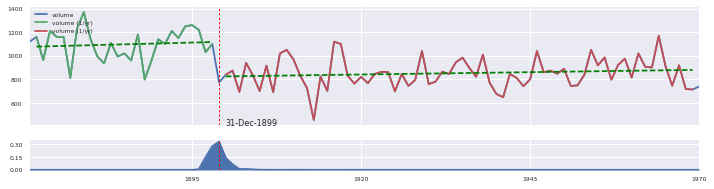

In [16]:
axes = plot_change(data, change)
segment(data, ['31-Dec-1899'], axes)